In [7]:
# Standard library imports
import pickle
import random
import sys
import time

# Third-party imports
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import GPy
from GPy.models import GPRegression
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool

# Visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Local imports
from src.utils import load_data, prep_data, predict_and_plot_SLC, filter_nan

# Styling settings
sns.set_style('whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'


In [ ]:
# IMPORTANT: If you want to test the code you can use a small value here and it should run fast
# If you want to reproduce the results in the paper use 
sample_size = 20 # For high quality plots sample_size=3000
num_rep = 5 # For high quality plots num_rep=30

In [8]:
data = load_data([0,151])


In [9]:
def calculate_optimal_density(data, sample_size, resolution=2, mean_melt=2.2):
    """Calculate optimal density estimation using GP regression and KDE.

    Args:
        data: Input dataframe containing simulation results
        sample_size: Number of samples to use
        resolution: Resolution level (default: 2)
        mean_melt: Mean melt rate (default: 2.2)

    Returns:
        Tuple of (CDF values, PDF values, sampled data points)
    """
    # Sample from prior distribution
    prior_mean = 2.2
    prior_std = 0.5
    X_m = np.random.lognormal(mean=prior_mean, sigma=prior_std, size=100).reshape(-1, 1)

    # Filter data for specific resolution and time
    data_sub = data[(data["resolution"] == resolution) & (data["years"] == 150)]

    # Find closest points to sampled values
    closest_points_indices = []
    for x_m in X_m[:sample_size].flatten():
        idx = (data_sub['melt_average'] - x_m).abs().argsort()[:1]
        closest_points_indices.append(idx.values[0])
    closest_points = data_sub.iloc[closest_points_indices]

    # Fit GP model
    X, Y, X_m = prep_data(closest_points, X_m=X_m)
    kernel = GPy.kern.RBF(input_dim=1, ARD=True, lengthscale=[1], variance=1)
    model = GPRegression(X, Y, kernel=kernel, normalizer=True, noise_var=1)
    model.optimize()

    # Generate samples from posterior
    mean, var = model.predict(X_m.reshape(-1, 1))
    samples = []
    for m, v in zip(mean, var):
        samples.extend(np.random.normal(m, np.sqrt(v), size=10))

    # Filter invalid values
    samples = filter_nan(np.array(samples).reshape(-1, 1))
    if len(samples) == 0:
        return None

    # Estimate density using KDE
    X_grid = np.linspace(0, 500, 100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(samples)
    log_density = kde.score_samples(X_grid)
    pdf = np.exp(log_density)

    # Calculate empirical CDF
    thresholds = range(0, 400, 5)
    cdf = [np.mean(samples.flatten() > t) for t in thresholds]

    return np.array(cdf), pdf, samples.flatten()

In [10]:
def initialize_budget_list(start=2, num_iterations=30):
    """Generate budget list with exponential growth."""
    budget_list = []
    for i in range(num_iterations):
        new_start = int(start * 1.5)
        if new_start - start > 500:
            start += 500
        else:
            start = new_start
        budget_list.append(start)
    return budget_list

def run_trials(data, num_points, resolution, mean_melt, opt_pdf, observed_2k, num_rep):
    """Run multiple trials and collect errors."""
    errors = []
    pdf_error_list = []

    for _ in range(num_rep):
        try:
            y_opt_cdf, new_pdf, new_val = calculate_optimal_density(
                data,
                num_points,
                resolution=resolution,
                mean_melt=mean_melt
            )
            pdf_error_list.append(np.abs(opt_pdf-new_pdf).sum())
            errors.append(wasserstein_distance(observed_2k, new_val))
        except:
            continue

    return errors, pdf_error_list

def evaluate_resolution(data, budget, resolution, cost, mean_melt, opt_pdf, observed_2k, num_rep):
    """Evaluate a specific resolution and budget combination."""
    num_points = min(budget//cost[resolution], 500)

    if num_points < 1:
        return None, None

    errors, pdf_error_list = run_trials(
        data,
        num_points,
        resolution,
        mean_melt,
        opt_pdf,
        observed_2k,
        num_rep
    )

    print(f"Resolution: {resolution}, Samples: {num_points}, Mean Error: {pdf_error_list}")
    return errors, pdf_error_list

def run():
    # Initialize parameters
    budget_list = initialize_budget_list()
    mean_errors = {}
    pdf_errors = {}
    cost = {2:70, 3:12, 4:8, 5:4, 6:3, 7:2, 8:1}

    # Test different melt rate scenarios
    for mean_melt, melt_label in [(2.2,10), (2.872,20), (3.52,40)]:
        # Calculate optimal density for reference
        opt_cdf, opt_pdf, observed_2k = calculate_optimal_density(
            data,
            sample_size,
            resolution=2,
            mean_melt=mean_melt
        )

        mean_errors[melt_label] = {}
        pdf_errors[melt_label] = {}

        # Test each resolution
        for res in range(2,9):
            mean_errors[melt_label][res] = {}
            pdf_errors[melt_label][res] = {}

            # Test each budget
            for budget in budget_list:
                errors, pdf_error_list = evaluate_resolution(
                    data,
                    budget,
                    res,
                    cost,
                    mean_melt,
                    opt_pdf,
                    observed_2k,
                    num_rep
                )

                mean_errors[melt_label][res][budget] = errors
                pdf_errors[melt_label][res][budget] = pdf_error_list
    return mean_errors, pdf_errors


In [11]:
mean_errors, pdf_errors = run()

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 2, Samples: 1, Mean Error: []
Nan detected skipping one iter
Resolution: 2, Samples: 2, Mean Error: [0.1527380422700295, 0.1046460731151804, 0.12059033321656384, 0.11175814737473616]
Resolution: 2, Samples: 3, Mean Error: [0.1347451352758984, 0.12796358718641518, 0.17210985411002855, 0.15985623681721833, 0.3443183284624201]
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 2, Samples: 4, Mean Error: [0.12006196433546917, 0.14254953462241046, 0.15364325695675127, 0.13098785121866363]
Resolution: 2, Samples: 6, Mean Error: [0.059150771967836864, 0.10597763661558762, 0.06346458251777413, 0.08284163699378938, 0.08567351266849524]
Resolution: 2, Samples: 10, Mean Error: [0.08870416344270071, 0.09941752861228571, 0.14166250635410865, 0.05773621293878213, 0.06570353178887245]
Resolution: 2, Samples: 15, Mean Error: [0.13518558832581914, 0.1360078468010702, 0.13744236082626543, 0.14114039745562237, 0.13963889369890098]
Resolution: 2, Samples: 22, Mean Error: [0.12349906478985795, 0.09551709711656434, 0.13531290251673442, 0.06452491031265246, 0.12295238664913058]
Resolution: 2, Samples: 29, Mean Error: [0.126065115597972, 0.11994121110416095, 0.1270657504196611, 0.14423807992954668, 0.13137928447035818]
Resolution: 2, Samples: 36, Mean Error: [0.1328978675890481, 0.1332798282986698, 0.09901734892217098, 0.1446553494187921, 0.11442252262375008]
Resolut

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 2, Mean Error: [0.09509870056703931, 0.16962059023075893]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 3, Samples: 3, Mean Error: [0.0529933962420403, 0.13184668683040768, 0.32098078485580156, 0.2012440469955244]
Resolution: 3, Samples: 5, Mean Error: [0.24693507454579605, 0.20171895126883999, 0.0673753925976723, 0.2533854900721346, 0.20947125685343518]
Resolution: 3, Samples: 7, Mean Error: [0.09025572191890163, 0.14510295006361187, 0.06754603982755508, 0.10986489090313079, 0.12499695029872931]
Resolution: 3, Samples: 11, Mean Error: [0.06513009369947567, 0.1254787256471512, 0.061609561838293775, 0.06241628872482795, 0.11645098810348721]
Resolution: 3, Samples: 17, Mean Error: [0.0978274839682017, 0.06883786627208172, 0.07801112454752196, 0.06753368142262117, 0.07903957763193678]
Resolution: 3, Samples: 26, Mean Error: [0.07577985311021235, 0.0947072220515362, 0.07053690905998054, 0.07042074485354752, 0.11010177210178348]
Resolution: 3, Samples: 39, Mean Error: [0.09405063460659291, 0.13402022498774468, 0.07732653429411532, 0.07441170309845475

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Resolution: 4, Samples: 2, Mean Error: [0.30740315501661114, 0.05612060315129058, 0.05665808502104223, 0.05102198893940245]
Resolution: 4, Samples: 3, Mean Error: [0.16810726215847763, 0.06785842859159183, 0.04726523068763745, 0.08905198915467065, 0.30379475904037634]
Nan detected skipping one iter
Resolution: 4, Samples: 5, Mean Error: [0.11421759383467213, 0.06666293847312782, 0.08451375763735555, 0.04752710394277414]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 4, Samples: 7, Mean Error: [0.1260988957029191, 0.10612048472033667, 0.06052680176820738, 0.05781898205814985, 0.06147078804246563]
Resolution: 4, Samples: 11, Mean Error: [0.06630591653992166, 0.053493410658946694, 0.12052104136740674, 0.061459073635170766, 0.07907203786058599]
Resolution: 4, Samples: 17, Mean Error: [0.08929495235021374, 0.07592459598413982, 0.07366028949886823, 0.05798846531494843, 0.08375840235578016]
Resolution: 4, Samples: 26, Mean Error: [0.09516112223525748, 0.06238940590699675, 0.056635459369445314, 0.10008037299821426, 0.049683414947545586]
Resolution: 4, Samples: 39, Mean Error: [0.07676637570529668, 0.061438265084848134, 0.05385436581592898, 0.08014548312239322, 0.05856881500812873]
Resolution: 4, Samples: 59, Mean Error: [0.06174369544253998, 0.05048335439346351, 0.06292940567148063, 0.05846244939101681, 0.07682969546846191]
Resolution: 4, Samples: 88, Mean Error: [0.0671635886577284, 0.07077375976444224, 0.08846305799141638, 0.0674065737351183

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 2, Mean Error: [0.06319529244936856, 0.057728884671463636, 0.3325027323533708]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 5, Samples: 3, Mean Error: [0.05074100295370351, 0.06256929967509192, 0.053604026593745226, 0.34470876790084437]
Nan detected skipping one iter
Resolution: 5, Samples: 4, Mean Error: [0.07268808550048224, 0.3305386604743342, 0.06495980057559142, 0.28519670071708986]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 5, Samples: 7, Mean Error: [0.07037586386361223, 0.05461355068705099, 0.08304809802658472, 0.08767010258571462, 0.32727970738484147]
Resolution: 5, Samples: 10, Mean Error: [0.08413843567622753, 0.0737746506030397, 0.06620232488828365, 0.11134899236654389, 0.08849285494068941]
Resolution: 5, Samples: 15, Mean Error: [0.087612169108672, 0.08823908605440756, 0.05201171549839685, 0.06493340526145097, 0.08787702428322569]
Resolution: 5, Samples: 23, Mean Error: [0.08593662333778132, 0.07196594894413608, 0.05608902328031948, 0.06360367777661338, 0.0666685583016754]
Resolution: 5, Samples: 35, Mean Error: [0.07769046980915154, 0.05594959459926825, 0.07408516157881834, 0.08441590601808627, 0.06827772314524529]
Resolution: 5, Samples: 52, Mean Error: [0.08180539662015647, 0.06661469699395223, 0.051019105635200096, 0.06336579094512443, 0.10352940366417482]
Resolution: 5, Samples: 79, Mean Error: [0.08870656260715387, 0.07041906188191298, 0.08572185119602144, 0.0692192050735815, 0.07

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 2, Mean Error: [0.12158229558524299, 0.12818506272188496, 0.1212142369012105]
Nan detected skipping one iter
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 6, Samples: 3, Mean Error: [0.36613139832807634, 0.15833598181955072]
Resolution: 6, Samples: 4, Mean Error: [0.11888117091568626, 0.11316771745691634, 0.3584976283143795, 0.17357468791266756, 0.16905430875783306]
Resolution: 6, Samples: 6, Mean Error: [0.20099078133834813, 0.15874402149980363, 0.15472459561026042, 0.1740941169194323, 0.3742826752301474]
Resolution: 6, Samples: 9, Mean Error: [0.19057321865427565, 0.2113588979252688, 0.1751626275488369, 0.13193660839211355, 0.13937997680960046]
Resolution: 6, Samples: 14, Mean Error: [0.1847094474124144, 0.21559381436207276, 0.18902099148780233, 0.20624430830811064, 0.2104367371031049]
Resolution: 6, Samples: 21, Mean Error: [0.1761091092716915, 0.19320039107387818, 0.1941731941211427, 0.1271600931040612, 0.19207310212969492]
Resolution: 6, Samples: 31, Mean Error: [0.19448434586013913, 0.2091097366502892, 0.1916624637539075, 0.22609989995684002, 0.22544674108333596]
Resolution: 6, Samples: 47

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 7, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 7, Samples: 2, Mean Error: [0.06070716001983024, 0.0744770766761695, 0.06418587639081717]
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 7, Samples: 3, Mean Error: [0.3490616198867326, 0.07470861761677891, 0.32303097885803367, 0.32908558757572615]
Resolution: 7, Samples: 4, Mean Error: [0.08594504302921475, 0.1114167680392318, 0.051078581073824014, 0.0916944839941688, 0.1175058370378138]
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 7, Samples: 6, Mean Error: [0.12471609062748314, 0.0653093487461701, 0.1355534688833106, 0.12680183837623737]
Resolution: 7, Samples: 9, Mean Error: [0.13179220659935253, 0.1154152818110935, 0.09312758351047502, 0.10300935591633574, 0.1480482666092803]
Resolution: 7, Samples: 14, Mean Error: [0.10634675456473874, 0.15287877060094, 0.13661751983447076, 0.12349699819958063, 0.08520436588381457]
Resolution: 7, Samples: 21, Mean Error: [0.11890828352639565, 0.1042098764251791, 0.13485181577883393, 0.15168692766252573, 0.11799743519453632]
Resolution: 7, Samples: 31, Mean Error: [0.0759629180992783, 0.12412543565423094, 0.11774910239629197, 0.11628063241596241, 0.09894235763172618]
Resolution: 7, Samples: 47, Mean Error: [0.12700325155735998, 0.12174305684146836, 0.09760653166266109, 0.09536116677398002, 0.10727935166948692]
Resolution: 7, Samples: 70, Mean Error: [0.11393114756302616, 0.13652240970982912, 0.1055620796275025, 0.1055026951901494, 0.10878683829986666]
Resolution: 

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 8, Samples: 3, Mean Error: [0.11555896996218415, 0.09950417551533655, 0.20941624022502178, 0.10812453074226652]
Resolution: 8, Samples: 4, Mean Error: [0.20724949803154938, 0.10524872811571886, 0.09227216492473617, 0.09937198266775224, 0.2079403248107519]
Resolution: 8, Samples: 6, Mean Error: [0.19808410695480244, 0.10682307677836586, 0.20107887055973203, 0.07327824736708587, 0.21364651651129601]
Resolution: 8, Samples: 9, Mean Error: [0.12453269085298768, 0.0882149178438299, 0.1554857262183409, 0.15886211095166006, 0.13091674645799875]
Resolution: 8, Samples: 13, Mean Error: [0.13929273595996705, 0.10995093952118665, 0.0705425395152737, 0.19756431517820683, 0.13267343457499342]
Resolution: 8, Samples: 19, Mean Error: [0.19424058519836515, 0.08989319394725502, 0.16428252407914157, 0.13680999246497016, 0.1369568850624669]
Resolution: 8, Samples: 28, Mean Error: [0.14234836209402646, 0.1113919315020643, 0.15743718447084576, 0.13589776217453028,

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 2, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 2, Samples: 2, Mean Error: [0.10208306192904248, 0.09102232586634515, 0.33445848598918904]
Resolution: 2, Samples: 3, Mean Error: [0.5838853693781559, 0.1487306299605764, 0.33378411720017626, 0.568754119331575, 0.15234412592014124]
Resolution: 2, Samples: 4, Mean Error: [0.10674568376576349, 0.09450893203290467, 0.17116510277860317, 0.1075660337367537, 0.3329378594102518]
Resolution: 2, Samples: 6, Mean Error: [0.11585907394459831, 0.10237267274182188, 0.04392741275988843, 0.079026168983791, 0.33695156231095763]
Resolution: 2, Samples: 10, Mean Error: [0.05668974925740884, 0.04003377590562237, 0.06763220437288311, 0.0753112588081997, 0.11454325630875979]
Resolution: 2, Samples: 15, Mean Error: [0.06107916948503419, 0.06279536782997885, 0.11543332745482991, 0.09261716882588544, 0.0

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 3, Samples: 2, Mean Error: [0.15271023928439825, 0.26298763282378995, 0.24062209642044846, 0.14909861424569182]
Nan detected skipping one iter
Resolution: 3, Samples: 3, Mean Error: [0.16811521913705846, 0.34913675985064524, 0.16253958170186342, 0.14716334042386497]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 3, Samples: 5, Mean Error: [0.15407347936925497, 0.18918668485723844, 0.14005616247966643, 0.31220415318584505, 0.14637621718537733]
Resolution: 3, Samples: 7, Mean Error: [0.125457092814332, 0.15422903812310984, 0.1750830844065996, 0.20982822363343268, 0.1762770605308404]
Resolution: 3, Samples: 11, Mean Error: [0.20994792751321734, 0.13153458812660898, 0.1928106842911067, 0.19872634668028538, 0.1350634569254805]
Resolution: 3, Samples: 17, Mean Error: [0.16179608346902344, 0.20805804477392514, 0.11812391943282083, 0.13832066209857055, 0.19609300306289534]
Resolution: 3, Samples: 26, Mean Error: [0.1731031056560281, 0.1750997132354068, 0.16153687009070583, 0.11284405200726119, 0.13111087941715563]
Resolution: 3, Samples: 39, Mean Error: [0.11813077020502741, 0.21682736456360743, 0.21250723856997122, 0.12075313116488635, 0.1962134344345094]
Resolution: 3, Samples: 59, Mean Error: [0.12168265804497787, 0.11768587211857781, 0.13503287837652, 0.1400097774128432, 0.128265527362

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 2, Mean Error: [0.12297972972685713]
Resolution: 4, Samples: 3, Mean Error: [0.24141389887382775, 0.23848146859964764, 0.12870533805034098, 0.3419347994505504, 0.3346648170965838]
Resolution: 4, Samples: 5, Mean Error: [0.12429955042725817, 0.12640439995920397, 0.11731988619604608, 0.22844310650675947, 0.17587333602025287]
Resolution: 4, Samples: 7, Mean Error: [0.0987676661219758, 0.18592719988280573, 0.0906456360302348, 0.15790649185247357, 0.2928030703918887]
Resolution: 4, Samples: 11, Mean Error: [0.13174075023240617, 0.1408060913476159, 0.14503815901166794, 0.15346825351443244, 0.12378562081550087]
Resolution: 4, Samples: 17, Mean Error: [0.18918374420877368, 0.1382911015662659, 0.11751656574447655, 0.10443167693548527, 0.13387925703613435]
Resolution: 4, Samples: 26, Mean Error: [0.13701004726826077, 0.12884160792801697, 0.18679894597374974, 0.1206941953022466, 0.18406597343502878]
Resolution: 

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 2, Mean Error: [0.3559852473680644, 0.10841089214283123]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 5, Samples: 3, Mean Error: [0.14079173049678, 0.15317603138014685, 0.36430640685860183, 0.12484819857256481]
Resolution: 5, Samples: 4, Mean Error: [0.16399946120862588, 0.14575938323113546, 0.16709938679260697, 0.3655930321705532, 0.12174504136637863]
Resolution: 5, Samples: 7, Mean Error: [0.16934203089541644, 0.30857694603849195, 0.08509897756973905, 0.18705528803115457, 0.1758498057392961]
Resolution: 5, Samples: 10, Mean Error: [0.24533442566725674, 0.13761462596713242, 0.19069148012853282, 0.17597217834404805, 0.13586342199609872]
Resolution: 5, Samples: 15, Mean Error: [0.18424693009364193, 0.15422995556042401, 0.1906276795848974, 0.16916697982722864, 0.172106677940394]
Resolution: 5, Samples: 23, Mean Error: [0.18548401337817016, 0.1741371724890023, 0.15173741985563122, 0.17754797406015882, 0.14819448109160338]
Resolution: 5, Samples: 35, Mean Error: [0.17620922525299423, 0.18412481746851256, 0.18625841098753482, 0.15143935523885027, 0

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 2, Mean Error: [0.3935011230087317]
Nan detected skipping one iter
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 6, Samples: 3, Mean Error: [0.22244555568989094, 0.24197773529437236, 0.377144486059345]
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 6, Samples: 4, Mean Error: [0.3496391667188236, 0.18585664563498222, 0.2313234377333247, 0.18149368456641735]
Resolution: 6, Samples: 6, Mean Error: [0.2646588397132844, 0.3438044286864347, 0.2565998274014272, 0.2705292119875681, 0.2640053080273922]
Resolution: 6, Samples: 9, Mean Error: [0.1909938371930871, 0.23263638607673898, 0.23874231006207297, 0.24032002197783942, 0.24585315403463415]
Resolution: 6, Samples: 14, Mean Error: [0.24279858878304095, 0.25720361997666474, 0.26272346595709895, 0.25181655681005755, 0.2689596754395166]
Resolution: 6, Samples: 21, Mean Error: [0.2722561565394823, 0.2247376557186924, 0.27672178636856093, 0.2719623178553747, 0.2761979710111257]
Resolution: 6, Samples: 31, Mean Error: [0.2618546444536365, 0.2753206336833448, 0.2577348510129863, 0.27651481323430294, 0.26909131075549697]
Resolution: 6, Samples: 47, Mean Error: [0.2606099575001328, 0.22312376899892458, 0.2740390580141197, 0.23584224423714822, 0.224737973548716]
Resolution: 6, Samples

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 7, Samples: 2, Mean Error: [0.14275472443774553, 0.3238206432548244, 0.37520377355537304, 0.380255898210861]
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 7, Samples: 3, Mean Error: [0.16695373710281602, 0.15981343019674601, 0.15519050339159518]
Resolution: 7, Samples: 4, Mean Error: [0.13453653815806796, 0.16821500443542597, 0.3815606788923819, 0.19806834496717957, 0.19219590518736018]
Resolution: 7, Samples: 6, Mean Error: [0.19035412574202876, 0.1749433047967976, 0.21029222389049942, 0.20067261765230623, 0.17203068663025417]
Resolution: 7, Samples: 9, Mean Error: [0.19833572916459472, 0.14149458253611785, 0.20787028691778633, 0.19897366984980552, 0.21172040382789614]
Resolution: 7, Samples: 14, Mean Error: [0.2139325008759717, 0.19218401457247486, 0.21650106572762626, 0.1736157438016442, 0.1929539456076842]
Resolution: 7, Samples: 21, Mean Error: [0.202815336104025, 0.20929214623477171, 0.21974444040126473, 0.202

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 2, Samples: 1, Mean Error: []
Nan detected skipping one iter
Resolution: 2, Samples: 2, Mean Error: [0.12411918887923522, 0.3502581795710444, 0.13960690804759568, 0.34696201591270426]
Resolution: 2, Samples: 3, Mean Error: [0.12132303773443857, 0.1431221908489174, 0.2090908168736883, 0.07665485944815917, 0.1364712715901263]
Resolution: 2, Samples: 4, Mean Error: [0.13434957059483527, 0.14351438456180893, 0.14494132172281526, 0.13463297730739254, 0.13737834292933043]
Resolution: 2, Samples: 6, Mean Error: [0.08872332269475991, 0.1505626826061925, 0.1674305295043922, 0.15851677468550532, 0.0824573287092553]
Resolution: 2, Samples: 10, Mean Error: [0.06517347491310381, 0.172921044633324, 0.08614905251145322, 0.15523165426216462, 0.14746817473178092]
Resolution: 2, Samples: 15, Mean Error: [0.15663251688383645, 0.149965223226

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 3, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Resolution: 3, Samples: 2, Mean Error: [0.1268005167590479, 0.18328982315311326, 0.29408143471230297, 0.36380162062534205]
Nan detected skipping one iter
Resolution: 3, Samples: 3, Mean Error: [0.35476038225069584, 0.3065614825660451, 0.1893863674911702, 0.17997671407471305]
Resolution: 3, Samples: 5, Mean Error: [0.23546366851030304, 0.22430296838697425, 0.22391157933693898, 0.22817712849876307, 0.32195860134853804]
Resolution: 3, Samples: 7, Mean Error: [0.1991598281141302, 0.20267020150917303, 0.23108094565340742, 0.2099899169946694, 0.14727238460622305]
Resolution: 3, Samples: 11, Mean Error: [0.1760410306289985, 0.22996472656883188, 0.19809743073899577, 0.2396575798980841, 0.24382144756035554]
Resolution: 3, Samples: 17, Mean Error: [0.2337408972624935, 0.21364679955631682, 0.19307772548856936, 0.16885692507010255, 0.2509283793118399]
Resolution: 3, Samples: 26, Mean Error: [0.19400049544159298, 0.1760603294782756, 0.18863263419983914, 0.197593181927

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 4, Samples: 1, Mean Error: []
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Resolution: 4, Samples: 2, Mean Error: [0.1769851023713928, 0.10434155432374528, 0.24387962519923723, 0.16922890016327546]
Nan detected skipping one iter
Resolution: 4, Samples: 3, Mean Error: [0.19427705086674407, 0.27564287132223286, 0.27936822247969445, 0.27216326161205]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 4, Samples: 5, Mean Error: [0.15260323058861305, 0.33624842061023436, 0.1961438585102679, 0.29805646712125033, 0.26316424549775747]
Resolution: 4, Samples: 7, Mean Error: [0.10431796512035472, 0.14673604753311617, 0.18347614094565784, 0.16012946762619262, 0.1696179081667456]
Resolution: 4, Samples: 11, Mean Error: [0.3263005943307764, 0.22996894874991947, 0.21396541800850202, 0.17575836170084155, 0.12049122919184241]
Resolution: 4, Samples: 17, Mean Error: [0.18908529545440744, 0.18363803485405253, 0.20633412625602854, 0.24733275725017478, 0.2106614744122636]
Resolution: 4, Samples: 26, Mean Error: [0.18036155765152764, 0.22079841435735487, 0.22334331914195693, 0.22761502662863636, 0.15685572835097342]
Resolution: 4, Samples: 39, Mean Error: [0.1288070664793217, 0.15826637549351444, 0.16046431100159536, 0.20393729654847056, 0.19240995215167633]
Resolution: 4, Samples: 59, Mean Error: [0.24206689117950894, 0.18264825117992411, 0.15345828390007035, 0.16838733913432627, 0.1642

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 5, Samples: 2, Mean Error: [0.35904465343121295, 0.34263853915410547, 0.3687922726835393]
Resolution: 5, Samples: 3, Mean Error: [0.16112192526333174, 0.17512781052338527, 0.37346060294247396, 0.345397299264117, 0.36632391578028733]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 5, Samples: 4, Mean Error: [0.3131434428094185, 0.21373273980229984, 0.19940670897286492, 0.21060382105762887, 0.3467929863946146]
Resolution: 5, Samples: 7, Mean Error: [0.19832068356971966, 0.17222174302871307, 0.21245179670111575, 0.16002649910288677, 0.22057927908473934]
Resolution: 5, Samples: 10, Mean Error: [0.18728066339514132, 0.2261220945042937, 0.20758296677578525, 0.21022220451846318, 0.22007323545877883]
Resolution: 5, Samples: 15, Mean Error: [0.2273170729746572, 0.21398381212347564, 0.1974329949744088, 0.18771921641188521, 0.2275876245115997]
Resolution: 5, Samples: 23, Mean Error: [0.22277058807963468, 0.19789352903781066, 0.20062887150947195, 0.2177473993211247, 0.19930916105425228]
Resolution: 5, Samples: 35, Mean Error: [0.17524710955791206, 0.14524223505027867, 0.20010332244094425, 0.15946068676398933, 0.19606482355371707]
Resolution: 5, Samples: 52, Mean Error: [0.21978298809742913, 0.1278556700183031, 0.18703344633562635, 0.2042034033840457, 0.17382649

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 1, Mean Error: []


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/p

Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 2, Mean Error: [0.21117479050649882]
Nan detected skipping one iter


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 6, Samples: 3, Mean Error: [0.19436384818523167, 0.2578454798294574]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Resolution: 6, Samples: 4, Mean Error: [0.28180916149469865, 0.28861582220442444, 0.35789587937221856, 0.27530181848135593, 0.26071129451378966]
Resolution: 6, Samples: 6, Mean Error: [0.25884716552846304, 0.26320940486739997, 0.24481530696436352, 0.2248856904208067, 0.2520788007372904]
Resolution: 6, Samples: 9, Mean Error: [0.2904442010035963, 0.2572079145773093, 0.29268087953612326, 0.2817059878248554, 0.2549503011215386]
Resolution: 6, Samples: 14, Mean Error: [0.28241917162525265, 0.28928514730070365, 0.2720788560512163, 0.23187398695758538, 0.29765729854777034]
Resolution: 6, Samples: 21, Mean Error: [0.26835342581346694, 0.2918130713016379, 0.2874179495178378, 0.2797845047372357, 0.2681562949145559]
Resolution: 6, Samples: 31, Mean Error: [0.2809682932074594, 0.2767493126611814, 0.2550153314827358, 0.2962543261889978, 0.27120090935681185]
Resolution: 6, Samples: 47, Mean Error: [0.30115278763209097, 0.2625568829091324, 0.29702676494582014, 0.2791324055974036, 0.27457787663582583

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 7, Samples: 1, Mean Error: []
Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 7, Samples: 2, Mean Error: [0.18574384662689902, 0.3448636937042407, 0.36528078214837567]


 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Resolution: 7, Samples: 3, Mean Error: [0.17143257139323861, 0.3515427843062632, 0.19637579977082859, 0.19394492245044728]
Nan detected skipping one iter
Resolution: 7, Samples: 4, Mean Error: [0.3553510344232618, 0.21841992475435085, 0.17241550424790822, 0.3491642706606588]
Resolution: 7, Samples: 6, Mean Error: [0.3570008854841865, 0.18553421482063046, 0.2197361514568159, 0.22894593237283326, 0.2040539303871245]
Resolution: 7, Samples: 9, Mean Error: [0.23584900496488187, 0.22904072624806088, 0.19640170856873, 0.229561219619215, 0.236368279044034]
Resolution: 7, Samples: 14, Mean Error: [0.2118732320231616, 0.2132515396061714, 0.22093025197011434, 0.23198009552158003, 0.23487555883238917]
Resolution: 7, Samples: 21, Mean Error: [0.23168892662019133, 0.23457532366001943, 0.23492418240971183, 0.2148694306238565, 0.24830363913938844]
Resolution: 7, Samples: 31, Mean Error: [0.22640607766429982, 0.22991507221341642, 0.2313567184634215, 0.20386790158832702, 

 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide
 /Users/pierrethodoroff/.pyenv/versions/3.8.13/lib/python3.8/site-packages/GPy/util/normalizer.py:96: RuntimeWarning:invalid value encountered in true_divide


Nan detected skipping one iter
Nan detected skipping one iter
Resolution: 8, Samples: 3, Mean Error: [0.2880671380719264, 0.10872720211112252, 0.2823291580630729]
Resolution: 8, Samples: 4, Mean Error: [0.2688052484885135, 0.3624419110418377, 0.19790221680225936, 0.2041817366712756, 0.230482542770977]
Resolution: 8, Samples: 6, Mean Error: [0.26966050917979967, 0.10035923520289872, 0.20472170242876098, 0.2030319557905333, 0.3636831308494112]
Resolution: 8, Samples: 9, Mean Error: [0.22069688595810844, 0.1876756856381376, 0.19143576548781696, 0.1774065830876748, 0.2392633086793684]
Resolution: 8, Samples: 13, Mean Error: [0.22117032556710392, 0.20898877886777142, 0.18196312480185295, 0.16260270894524737, 0.1946511977205848]
Resolution: 8, Samples: 19, Mean Error: [0.16878663269684135, 0.2558275347891428, 0.1925830122286092, 0.17468655484580153, 0.23139359654696395]
Resolution: 8, Samples: 28, Mean Error: [0.16339872374238634, 0.19233639585750367, 0.1917552651868913, 0.21226247552520966,

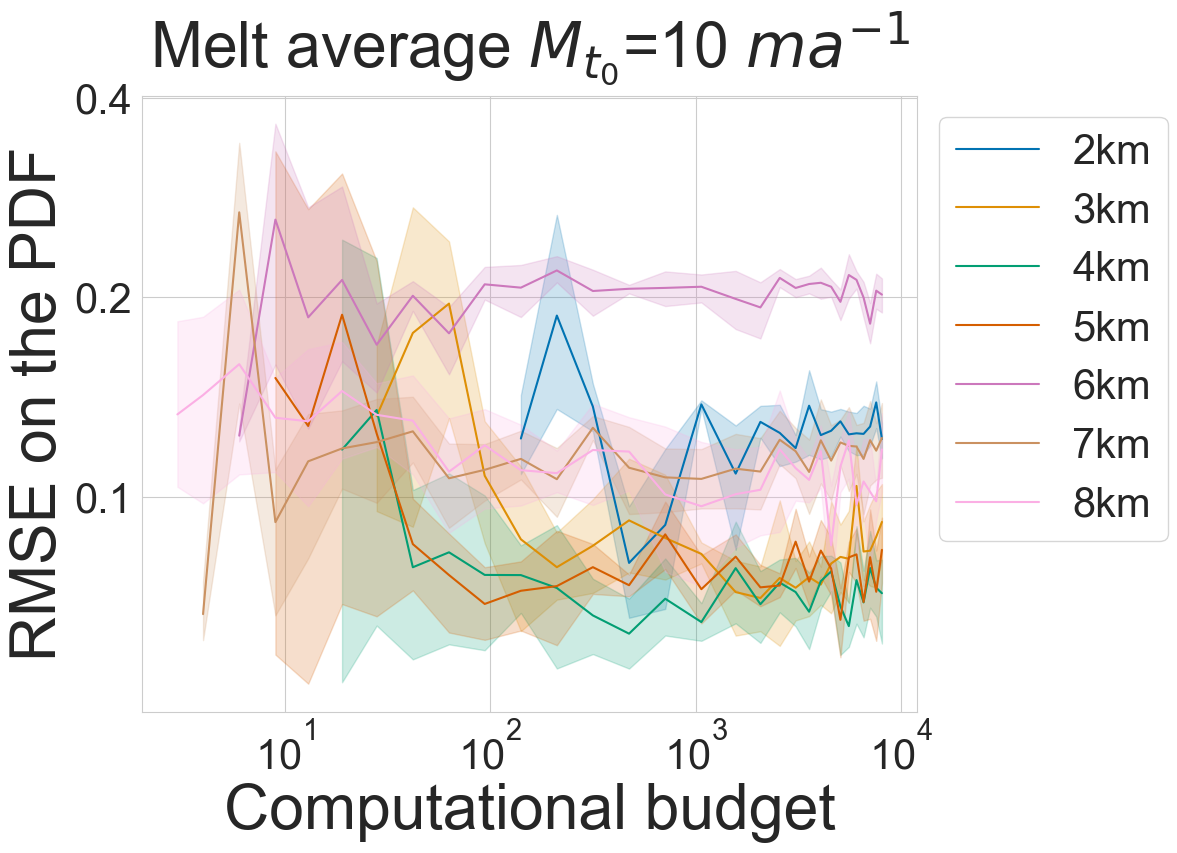

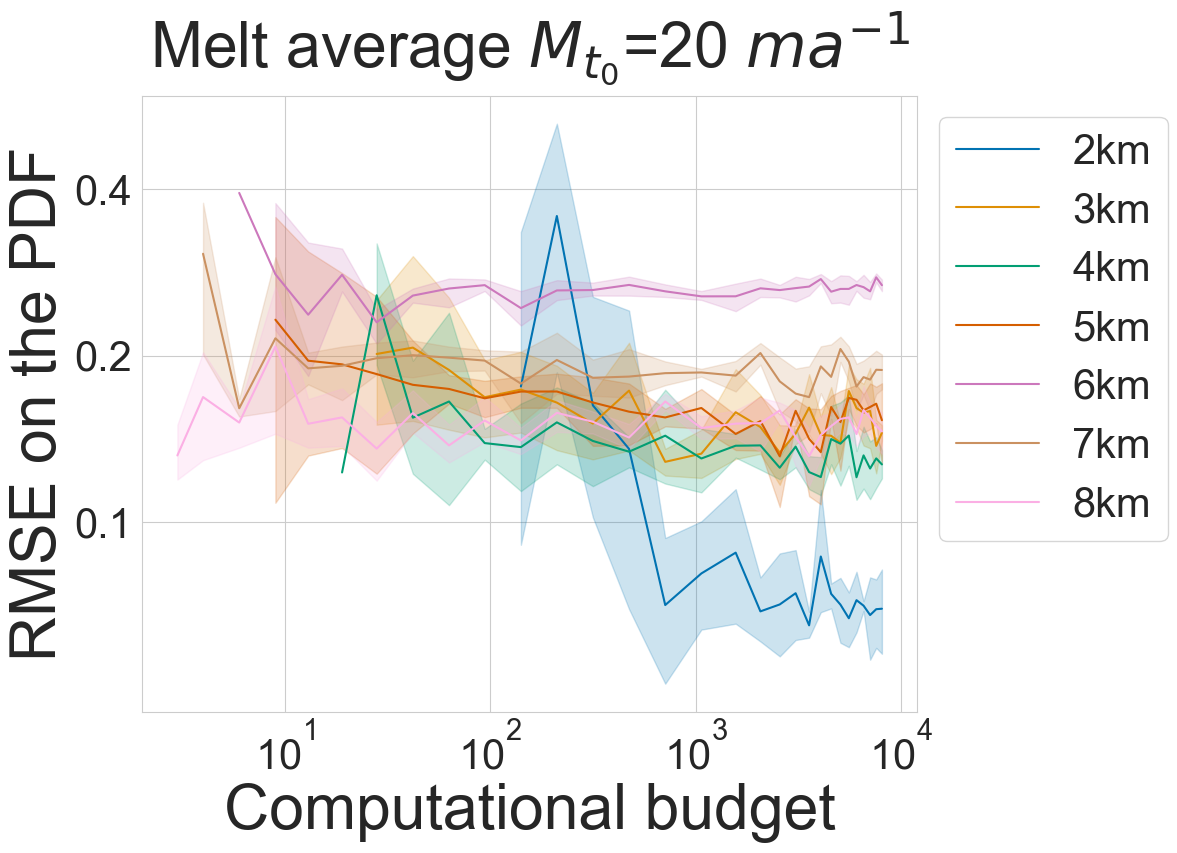

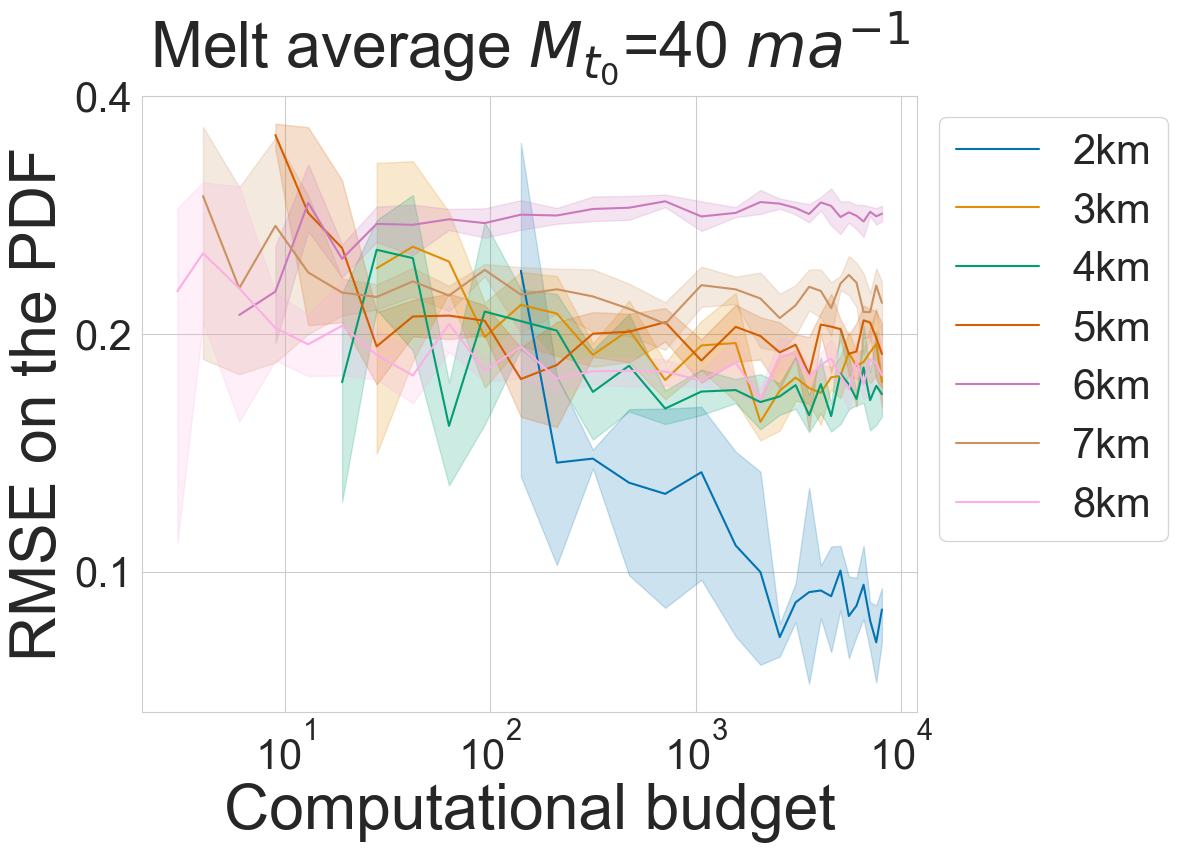

In [12]:
def create_pdf_errors_df(pdf_errors):
    """Convert nested pdf_errors dict into a pandas DataFrame."""
    data_for_df = []
    for melt_label, res_dict in pdf_errors.items():
        for res, budget_dict in res_dict.items():
            for budget, error_list in budget_dict.items():
                if error_list is not None:
                    for error in error_list:
                        data_for_df.append({
                            "res": str(res)+"km",
                            "budget": budget,
                            "melt_label": melt_label,
                            "error": error
                        })
    return pd.DataFrame(data_for_df)


def create_error_plot(df, label):
    """Create and save error plot for given melt label."""
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df[df['melt_label'] == label], x="budget", y="error", hue="res")

    # Configure scales and labels
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Computational budget", fontsize=45)
    plt.ylabel("RMSE on the PDF", fontsize=45)
    plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize=30, title_fontsize=45)
    plt.title(f"Melt average "+r'$M_{t_0}$'+f"={label} "+ r'$ma^{-1}$', fontsize=45, pad=20)

    # Configure axis properties
    ax = plt.gca()
    ax.set_yticks([0.1, 0.2, 0.4])
    ax.set_yticklabels(['0.1', '0.2', '0.4'])
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.grid(True, which='major', linestyle='-', linewidth=0.8)

    # Set y-axis limits
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(min(y_min, 0.1), max(y_max, 0.4))

    # Save and display
    path = f"./../assets/plots/fig_6/comp_{str(label)}_v2.pdf"
    plt.savefig(path, bbox_inches='tight')
    plt.show()

# Create dataframe and plots
pdf_errors_df = create_pdf_errors_df(pdf_errors)

for label in pdf_errors_df['melt_label'].unique():
    create_error_plot(pdf_errors_df, label)
